In [1]:
import kplr
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as SS
%matplotlib inline

#  Exoplanetas Transitantes con *Kepler*

El candidato a exoplaneta que se trabajará a continuación es KOI 1274.01 

Primero descargamos los datos de la fotometría PDCSAP

In [2]:
client = kplr.API()
koi = client.koi(1274.01)

lcs = koi.get_light_curves(short_cadence=True)

in_time, in_flux, in_flux_err= [], [], []
for lc in lcs:
    with lc.open() as f:
        hdu_data = f[1].data
        in_time.append(hdu_data["time"])
        in_flux.append(hdu_data["pdcsap_flux"])
        in_flux_err.append(hdu_data["pdcsap_flux_err"])

In [3]:
import scipy.signal as SS

def remove_nan_list(xarray,yarray,zarray):
    nans = np.isnan(yarray) #da un arreglo de boleanos de los elementos == np.nan
    index_nans = np.where(nans) #da los indices del arreglo donde la condicione es True (es un np.nan)
    for element in index_nans:
        xarray = np.delete(xarray,element)
        yarray = np.delete(yarray,element)
        zarray = np.delete(zarray,element)
    return xarray, yarray, zarray

def unir(time, flux, flux_err,win): #genera un unico arreglo sin np.nan y manteniendo las dimensiones de todos ellos igual
    total_time, total_flux1, total_flux2, total_flux_err = [], [], [], []
    new_time, new_flux, new_flux_err = remove_nan_list(time[0],flux[0],flux_err[0])
    new_flux1 = SS.medfilt(new_flux,win)#Se aplica un median filter al primer quarter
    new_flux2 = new_flux
    total_time = np.concatenate((total_time,new_time),axis=0)
    total_flux1 = np.concatenate((total_flux1,new_flux1),axis=0)
    total_flux2 = np.concatenate((total_flux2,new_flux2),axis=0)
    total_flux_err = np.concatenate((total_flux_err,new_flux_err),axis=0)
    offset = 0

    for i in range(0,len(time)-1):
        last_flux = new_flux
        new_time, new_flux, new_flux_err =remove_nan_list(time[i+1],flux[i+1],flux_err[i+1])
        offset = np.median(new_flux) - np.median(last_flux)# la resta de esos puntos dice cuan corrida esta la siguiente de la actual
        new_line = new_flux - offset# la curva siguiente es movida a la altura (mediana) de la curva actual
        new_flux = new_line
        new_flux1 = SS.medfilt(new_flux,win)#Se aplica un median filter a los otros quarters
        new_flux2 = new_flux
        total_time = np.concatenate((total_time,new_time),axis=0)
        total_flux1 = np.concatenate((total_flux1,new_flux1),axis=0)
        total_flux2 = np.concatenate((total_flux2,new_flux2),axis=0)
        total_flux_err = np.concatenate((total_flux_err,new_flux_err),axis=0)

    return total_time, total_flux1, total_flux2, total_flux_err 

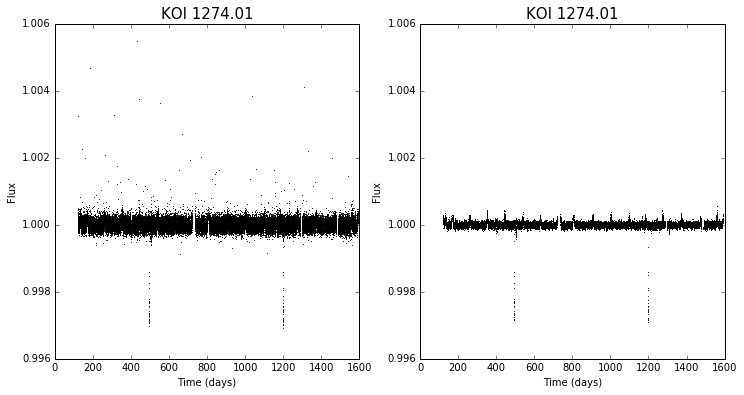

In [4]:
#una versión modificada de la función de la tarea pasada, esta vez retorna un flujo unido con la corrección por median filter
no_nan_time, no_nan_flux1, no_nan_flux2, no_nan_flux_err = unir(in_time, in_flux, in_flux_err,501)

total_flux = no_nan_flux2/no_nan_flux1
flux_err = no_nan_flux_err/no_nan_flux1

total_flux = SS.medfilt(total_flux,9)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=[6*2, 6])
ax[0].plot(no_nan_time,no_nan_flux2/no_nan_flux1,'k.',ms=1)
ax[0].set(xlabel='Time (days)', ylabel='Flux',ylim=(0.996,1.006))
ax[0].set_title("KOI 1274.01",size = 15)

ax[1].plot(no_nan_time,total_flux,'k.',ms=1)
ax[1].set(xlabel='Time (days)', ylabel='Flux',ylim=(0.996,1.006))
ax[1].set_title("KOI 1274.01",size = 15)

Se han normalizado todos los flujos, es decir, se dividió la curva de luz original en la que fue corregida por median filter, en la imagen de la izquierda se ve eso, mientras que en la imagen de la derecha muestra la curva de luz de la izquierda, pero a la que se le ha vuelto a corregir por otro median filter, en ambas imágenes se notan dos tránsitos. 

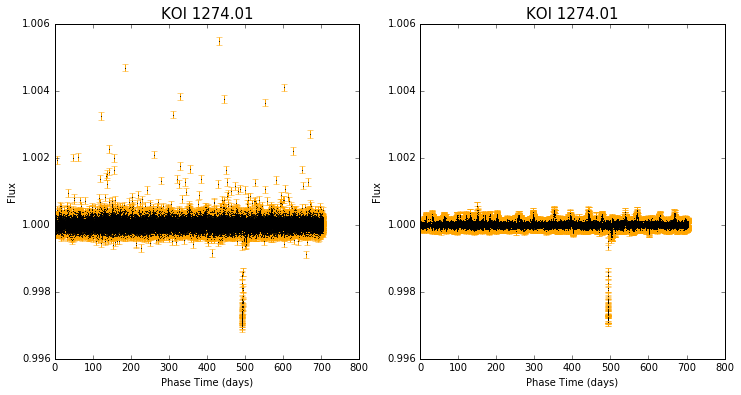

In [5]:
period = 704.2
phase = ((no_nan_time / period) % 1) * period

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=[6*2, 6])
ax[0].errorbar(phase,no_nan_flux2/no_nan_flux1,flux_err,fmt='.k',ecolor='orange',ms=1)
ax[0].set(xlabel='Phase Time (days)', ylabel='Flux',ylim=(0.996,1.006))
ax[0].set_title("KOI 1274.01",size = 15)

ax[1].errorbar(phase,total_flux,flux_err,fmt='.k',ecolor='orange',ms=1)
ax[1].set(xlabel='Phase Time (days)', ylabel='Flux',ylim=(0.996,1.006))
ax[1].set_title("KOI 1274.01",size = 15)


Luego se fasean las curvas de luz y se multiplican por el periódo del planeta (704.2 días) para visualizar mejor la escala del tránsito con respecto al periódo del planeta, se grafican con sus respectivos errores (naranjo)

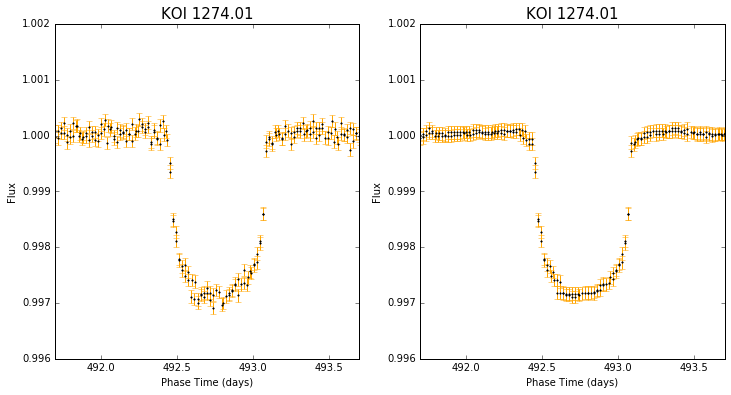

In [6]:
t_min = phase[np.argmin(total_flux)] #ubica el tiempo donde el flujo es minimo

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=[6*2, 6])
ax[0].errorbar(phase,no_nan_flux2/no_nan_flux1,flux_err,fmt='.k',ecolor='orange',ms=3)
ax[0].set(xlabel='Phase Time (days)', ylabel='Flux',ylim=(0.996,1.002),xlim=(t_min - 1, t_min + 1))
ax[0].set_title("KOI 1274.01",size = 15)

ax[1].errorbar(phase,total_flux,flux_err,fmt='.k',ecolor='orange',ms=3)
ax[1].set(xlabel='Phase Time (days)', ylabel='Flux',ylim=(0.996,1.002),xlim=(t_min - 1, t_min + 1))
ax[1].set_title("KOI 1274.01",size = 15)


Realizando un zoom a la sección correspondiente al transito se obtienen las curvas de arriba.

El análisis posterior se realizará segun el gráfico de la derecha, para ello se define la función ordenar, que ordena los datos de menos a mayor tiempo, para realizar un ajuste óptimo, además se resta *t_min* a al tiempo total para dejar la escala centrada en 0 donde el se alcanzo el menor flujo.

In [7]:
def ordenar(phase,flux,flux_err):
#se ocupa para poder ordenar los puntos de la fase de menor a mayor ya que no lo estan originalmente en la posición dentro del arreglo
    aux = {}
    all_phases = []
    for i in range (0,len(phase)):
        if phase[i] > 491.0 and phase[i] < 494.0:#acotamos el periodo para visualizar mejor el transito
            all_phases.append(phase[i])
            aux[phase[i]] = [flux[i],flux_err[i]]
    all_phases = np.array(all_phases)
    all_phases.sort()
    new_phases, new_flux, new_flux_err = [], [], []
    for element in all_phases:
        new_phases.append(element)
        new_flux.append(aux[element][0])
        new_flux_err.append(aux[element][1])   
        
    return np.array(new_phases), np.array(new_flux), np.array(new_flux_err)

x,y,z = ordenar(phase,total_flux,no_nan_flux_err/no_nan_flux1)
x = x - t_min


De acuerdo al artículo de Seager & Mallen-Ornelas (2002), los parametro que se pueden inferir al mirar la curva de luz en donde se aprecia el transito son:
+ La diferencia de flujo $\Delta F$
+ El tiempo de tránsito $t_{T}$
+ El tiempo de tránsito de la parte plana $t_{F}$
+ El periódo $P$

A partir de estos parámetros se pueden calcular otros parámetros necesarios para el cálculo de un tránsito tales como:
___
El radio del planeta en unidades estelares

$\frac{R_{p}}{R_{*}} = \sqrt{\Delta F}$
___

El parametro de impacto

$ b = \frac{a}{R_{*}}cos(i) = \left[\frac{\left(1-\sqrt{\Delta F}\right)^{2} - \frac{sin^{2}\left(\frac{t_{F}\pi}{P} \right)}{sin^{2}\left(\frac{t_{T}\pi}{P} \right)} \left(1+\sqrt{\Delta F}\right)^{2} }{1-\frac{sin^{2}\left(\frac{t_{F}\pi}{P} \right)}{sin^{2}\left(\frac{t_{T}\pi}{P} \right)}}  \right]^{\frac{1}{2}}$
___
La longitud del semieje mayor en unidades estelares

$\frac{a}{R_{*}} = \left[ \frac{\left(1+\sqrt{\Delta F}\right)^{2} - b^{2}\left( 1 - sin^{2}\left(\frac{t_{T}\pi}{P} \right) \right)}{sin^{2}\left(\frac{t_{T}\pi}{P} \right)} \right]^{\frac{1}{2}}$
___
La densidad de la estrella

$ \rho_{*} = \left( \frac{4\pi^{2}}{P^{2}G} \right) \left( \frac{a}{R_{*}} \right)^{3}$
___

In [8]:
def printear(R_rp, R_b, R_a, R_i,R_DF, R_tT, R_tF,R_d1,R_d2,R_t0):
    print "\n\n======================================================"
    print "DF:",R_DF
    print "tT:",R_tT
    print "tF:",R_tF
    print "rp:",R_rp
    print "a: ",R_a
    print "b: ",R_b
    print "i: ",R_i
    print "u1:",R_d1
    print "u2:",R_d2
    print "t0:",R_t0
    print "======================================================\n"

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.7554e-10                                    1.17e-05    
       1              2         2.1974e-10      5.56e-10       1.95e-01       2.03e-06    
       2              3         3.2369e-11      1.87e-10       1.02e-01       1.11e-06    
       3              4         5.1878e-12      2.72e-11       9.59e-02       4.91e-07    
       4              5         1.0968e-12      4.09e-12       2.09e-01       3.32e-07    
       5              6         3.8795e-13      7.09e-13       3.38e-02       6.46e-08    
       6              7         1.5671e-13      2.31e-13       7.79e-02       5.51e-08    
       7              8         7.6797e-14      7.99e-14       2.71e-01       9.41e-08    
       8              9         3.6329e-14      4.05e-14       4.34e-02       8.10e-09    
`gtol` termination condition is satisfied.
Function evaluations: 9, initial cost: 7.7554e-

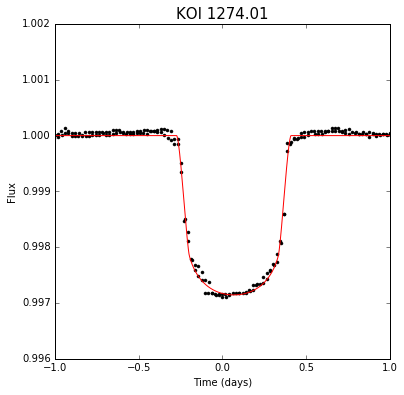

In [9]:
import batman
from scipy.interpolate import interp1d
from scipy.optimize import least_squares

DF0 = 0.003
tT0 = 0.5
tF0 = 0.25
P0 = 704.2

def parametros(DF,tT,tF,P):
    rp = np.sqrt(DF)

    aux = ((np.sin(tF*np.pi/P))/(np.sin(tT*np.pi/P)))**2
    b = np.sqrt( ((1-rp)**2 - aux*(1+rp)**2)/(1 - aux) )
    a = np.sqrt( ((1+rp)**2 - (b**2)*(1-np.sin(tT*np.pi/P)**2))/(np.sin(tT*np.pi/P)**2) )
    i = np.arccos(b/a) * 180/(np.pi)
    return rp,b,a,i

def baticristo(time,DF,tT,tF,P,d1,d2,t0):
    rp,b,a,i = parametros(DF,tT,tF,P)
    params = batman.TransitParams()
    params.t0 = t0                       #time of inferior conjunction
    params.per = P                       #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = a                         #semi-major axis (in units of stellar radii)
    params.inc = i                       #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [d1,d2]#[0.814, -0.08]                  #limb darkening coefficients
    params.limb_dark = "quadratic"       #limb darkening model

    m = batman.TransitModel(params, time) #initializes model
    flux = m.light_curve(params)          #calculates light curve
    f = interp1d(time, flux)
    model = f(time)
    return model
    
#ajuste lineal a los puntos de la curva de luz
ajuste = interp1d(x, y, kind='linear')

def err(params, time):
    DF,tT,tF,d1,d2,t0 = params
    return (ajuste(time) - baticristo(time,DF,tT,tF,P0,d1,d2,t0))**2

#ajuste al ojo de los parametros obtenidos de la curva de luz
time = np.linspace(-1, 1, 1000)
flux = baticristo(time,DF0,tT0,tF0,P0,0.1,0.1,0.1)

x0 = [DF0,tT0,tF0,0.1,0.1,0.1]
lo = [DF0-100,0,0,-1,-1,0]
hi = [DF0+100,tT0+100.0,tF0+100,5,5,1]

#minimos cuadrados para encontrar el los mejores parametros
result = least_squares(err, x0, args=(time,), bounds=(lo, hi), verbose=2)

#Parametros obtenidos del ajuste de minimos cuadrados
R_rp, R_b, R_a, R_i = parametros(result.x[0],result.x[1],result.x[2],P0) 
R_DF, R_tT, R_tF,R_d1,R_d2,R_t0 = result.x[0],result.x[1], result.x[2],result.x[3],result.x[4], result.x[5]
printear(R_rp, R_b, R_a, R_i,R_DF, R_tT, R_tF,R_d1,R_d2,R_t0)

R_flux = baticristo(time, R_DF, R_tT, R_tF, P0, R_d1, R_d2,R_t0)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[6, 6])
ax.errorbar(x,y,fmt='.k',ecolor='orange',ms=6)#curva ajustada a partir de los puntos
#ax.plot(time,flux,'b')#fit con los parametros al ojo
ax.plot(time,R_flux,'r')#fit con los mejores parametros del least_squares
ax.set(xlabel='Time (days)', ylabel='Flux',ylim=(0.996,1.002),xlim=(- 1, 1))
ax.set_title("KOI 1274.01",size = 15)

El ajuste (color rojo) se realizó usando *least_squares* variando los parametros: $\Delta F$, $t_{T}$, $t_{F}$, $u_{1}$, $u_{2}$ y $t_{0}$ (que es un parametro que corre la curva en el eje x), el periódo se de deja fijo. Los parámetros resultantes se encuentran un poco mas arriba.    

Sin embargo, se procede a calcular los coeficiente de limb darking de manera que se espécifica en el enunciado (Espinoza & Jordán 2015 ) los parámetros que resulten de este procedimiento se considerarán en el análisis pues no se sabe como afecta la iteración de los coeficientes de limb darking en los demás parámetros, primero se obtiene la cuerva de respuesta de *Kepler* (http://keplerscience.arc.nasa.gov/data/documentation/KSCI-19033-001.pdf)

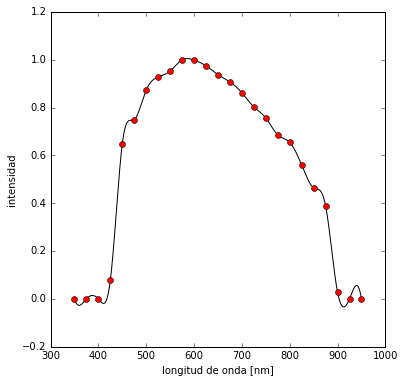

In [10]:
data = np.loadtxt('kepler_params')

ajuste1 = interp1d(data[:,0],data[:,1], kind='cubic')

min_l = np.min(data[:,0])
max_l = np.max(data[:,0])
l = np.linspace(min_l, max_l, 1000)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[6, 6])
ax.plot(l,ajuste1(l),'-k')
ax.plot(data[:,0],data[:,1],'or')
ax.set(xlabel='longitud de onda [nm]', ylabel='intensidad')

Luego se realiza un ajuste polinomial para determinar los coeficientes de limb darking

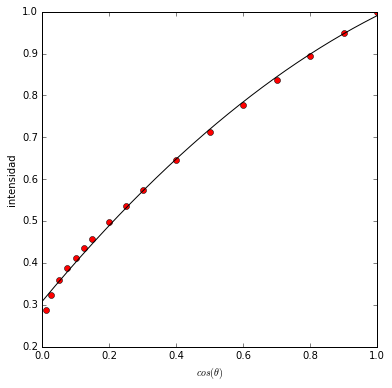

In [11]:
data = np.loadtxt('grav_4.5_lh_1.25.dat',comments='#') #archivo con el modelo de ATLAS9
inten = []
long_onda = []

aux = []
for element in data:
    if element[0] > min_l and element[0] < max_l:
        aux.append(element)
        
aux = np.array(aux)
        
long_onda = aux[:,0]
inten.append(aux[:,1])
for i in range(2,18):
    inten.append( aux[:,i]*1e-5*aux[:,1]) 
    
inten=np.array(inten)
inten = np.average(inten,axis=1,weights=ajuste1(long_onda))
cos_theta = [1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.25,0.2,0.15,0.125,0.1,0.075,0.05,0.025,0.01]
cos_theta = np.array(cos_theta)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[6, 6])
ax.plot(cos_theta,inten/inten[0],'or')
ax.set(xlabel='$cos( \\theta ) $', ylabel='intensidad')

#==========esto no lo entendi bien===================
ajuste2 = np.polyfit(1-cos_theta,inten/inten[0],2)
mu = np.linspace(0,1,1000)
f = np.poly1d(ajuste2)
inten2 = f(1-mu)

ax.plot(mu,inten2,'-k')

u1 = -ajuste2[1]
u2 = -ajuste2[0]
#=======pedi ayuda para implementarlo================
#Maty B.

Así se ajusta un polinomio cuadrático (linea negra) a los puntos con de ATLAS9 con el peso de la curva de respuesta

Finalmente se realiza nuevamente el modelo de *batman*, pero esta vez se dejan fijos los coeficientes de limb darking

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.7051e-10                                    2.19e-05    
       1              2         1.7692e-10      7.94e-10       2.01e-01       9.61e-06    
       2              3         1.9375e-11      1.58e-10       1.00e-01       8.65e-07    
       3              4         4.7226e-12      1.47e-11       2.70e-01       1.50e-06    
       4              5         8.8621e-13      3.84e-12       3.16e-02       3.79e-08    
       5              6         2.9993e-13      5.86e-13       1.35e-01       2.65e-07    
       6              7         6.5074e-14      2.35e-13       1.93e-02       2.09e-08    
       7              8         3.2225e-14      3.28e-14       3.62e-02       2.73e-08    
       8              9         2.7105e-14      5.12e-15       1.07e-02       5.05e-09    
`gtol` termination condition is satisfied.
Function evaluations: 9, initial cost: 9.7051e-

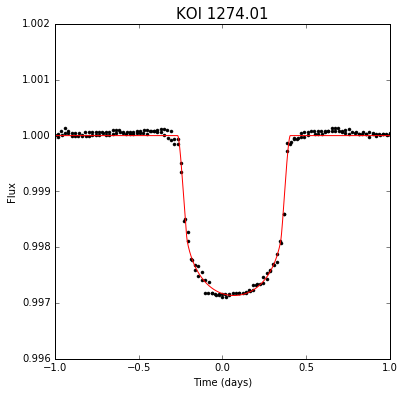

In [12]:
import batman
from scipy.interpolate import interp1d
from scipy.optimize import least_squares

DF0 = 0.003
tT0 = 0.5
tF0 = 0.25
P0 = 704.2

def parametros(DF,tT,tF,P):
    rp = np.sqrt(DF)

    aux = ((np.sin(tF*np.pi/P))/(np.sin(tT*np.pi/P)))**2
    b = np.sqrt( ((1-rp)**2 - aux*(1+rp)**2)/(1 - aux) )
    a = np.sqrt( ((1+rp)**2 - (b**2)*(1-np.sin(tT*np.pi/P)**2))/(np.sin(tT*np.pi/P)**2) )
    i = np.arccos(b/a) * 180/(np.pi)
    return rp,b,a,i

def baticristo(time,DF,tT,tF,P,t0):
    rp,b,a,i = parametros(DF,tT,tF,P)
    params = batman.TransitParams()
    params.t0 = t0                       #time of inferior conjunction
    params.per = P                       #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = a                         #semi-major axis (in units of stellar radii)
    params.inc = i                       #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [u1,u2]#[0.814, -0.08]    #limb darkening coefficients
    params.limb_dark = "quadratic"       #limb darkening model

    m = batman.TransitModel(params, time) #initializes model
    flux = m.light_curve(params)          #calculates light curve
    f = interp1d(time, flux)
    model = f(time)
    return model
    
#ajuste lineal a los puntos de la curva de luz
ajuste = interp1d(x, y, kind='linear')

def err(params, time):
    DF,tT,tF,t0 = params
    return (ajuste(time) - baticristo(time,DF,tT,tF,P0,t0))**2

#ajuste al ojo de los parametros obtenidos de la curva de luz
time = np.linspace(-1, 1, 1000)
flux = baticristo(time,DF0,tT0,tF0,P0,0.1)

x0 = [DF0,tT0,tF0,0.1]
lo = [DF0-100,0,0,0]
hi = [DF0+100,tT0+100.0,tF0+100,1]

#minimos cuadrados para encontrar el los mejores parametros
result = least_squares(err, x0, args=(time,), bounds=(lo, hi), verbose=2)

#Parametros obtenidos del ajuste de minimos cuadrados
R_rp, R_b, R_a, R_i = parametros(result.x[0],result.x[1],result.x[2],P0) 
R_DF, R_tT, R_tF,R_t0 = result.x[0],result.x[1], result.x[2],result.x[3]
printear(R_rp, R_b, R_a, R_i,R_DF, R_tT, R_tF,u1,u2,R_t0)

R_flux = baticristo(time, R_DF, R_tT, R_tF, P0, R_t0)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[6, 6])
ax.errorbar(x,y,fmt='.k',ecolor='orange',ms=6)#curva ajustada a partir de los puntos
#ax.plot(time,flux,'b')#fit con los parametros al ojo
ax.plot(time,R_flux,'r')#fit con los mejores parametros del least_squares
ax.set(xlabel='Time (days)', ylabel='Flux',ylim=(0.996,1.002),xlim=(- 1, 1))
ax.set_title("KOI 1274.01",size = 15)


En conclusión se obtienen los siguientes parámetros del último ajuste

|Parámetro        |Obtenido | Kipping et al. 2014 |Diferencia|
|:---------------:|:---------------:|:---------------:| :---------------:| 
|$a / R_{*}$| 273.572| 346 | 20.93% |
|$Rp / R_{*}$|0.051| 0.05  | 2% |
|$i\ [^{o}]$| 89.861 | 89.965 | 0.11% | 
 
Más los otros parámetros listados más arriba correspondientes al fitting

En unidades físicas se tiene:
+ $a = 1.783\ UA$
+ $Rp = 7.895\ R_{\oplus}$
+ $M_{*} = 1.524\ M_{\odot}$
+ $R_{*} = 1.401\ R_{\odot}$

In [13]:
R_S = 0.5*1.392 * 10**6 #Km
M_S =  1.989 * 10**30 #Kg
R_T = 6371 #Km
UA = 1.495 * 10**11 #m
G = 6.67*1e-11

rho = (365.25**2 / ((215**3)*P0**2))*R_a**3
exp = 1. / (1-3*0.8)
R = rho**(0.8*exp)
M = rho**exp
Rp = R * np.sqrt(R_DF)*R_S/R_T
a = (((((P0*60*60*24)**2)*G*M*M_S)/(4*np.pi**2))**(1./3))/UA